### Import Neccessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso ,Ridge , LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
df = pd.read_excel('premiums_young_with_gr.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [3]:
df.shape

(20096, 14)

In [4]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4


### Handling NA Values

In [5]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [7]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [9]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1])

In [10]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [11]:
numeric_columns = df.select_dtypes(['int64','float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

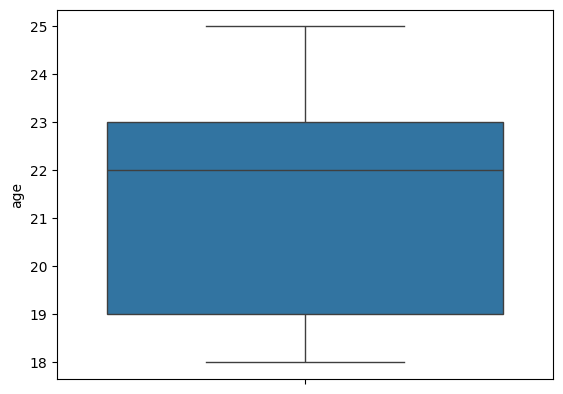

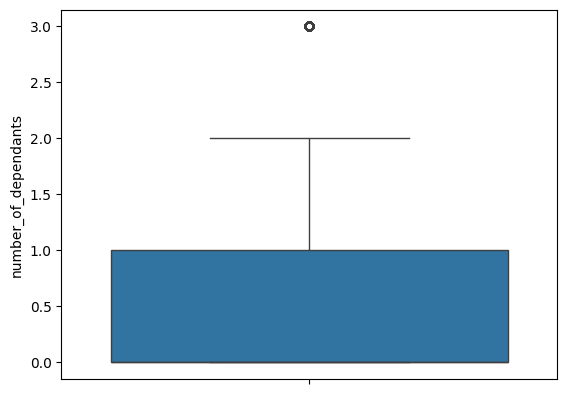

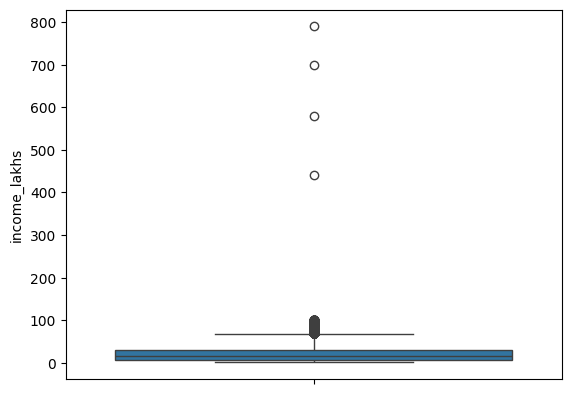

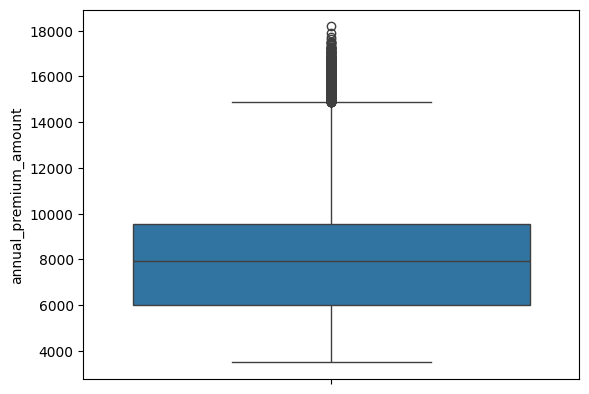

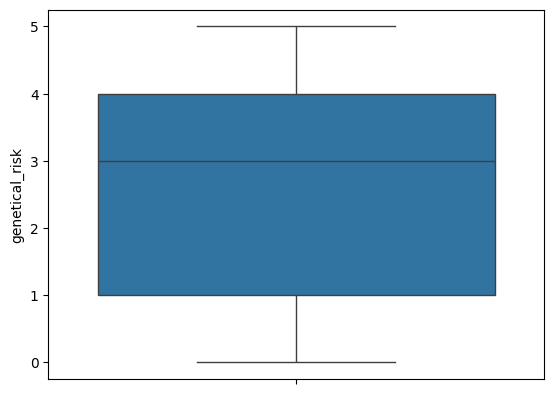

In [12]:
for col in numeric_columns:
    sns.boxplot(df[col])
    plt.show()

In [13]:
df[df['age'] > 100 ]['age'].unique()

array([], dtype=int64)

In [14]:
df1 = df[df['age']<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [15]:
def get_iqr_bounds(col) :
    Q1,Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound,upper_bound

In [16]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [17]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [18]:
df1[df1.income_lakhs > quantile_threshold].shape

(4, 14)

In [19]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


### Exploratory Data Analysis (EDA)

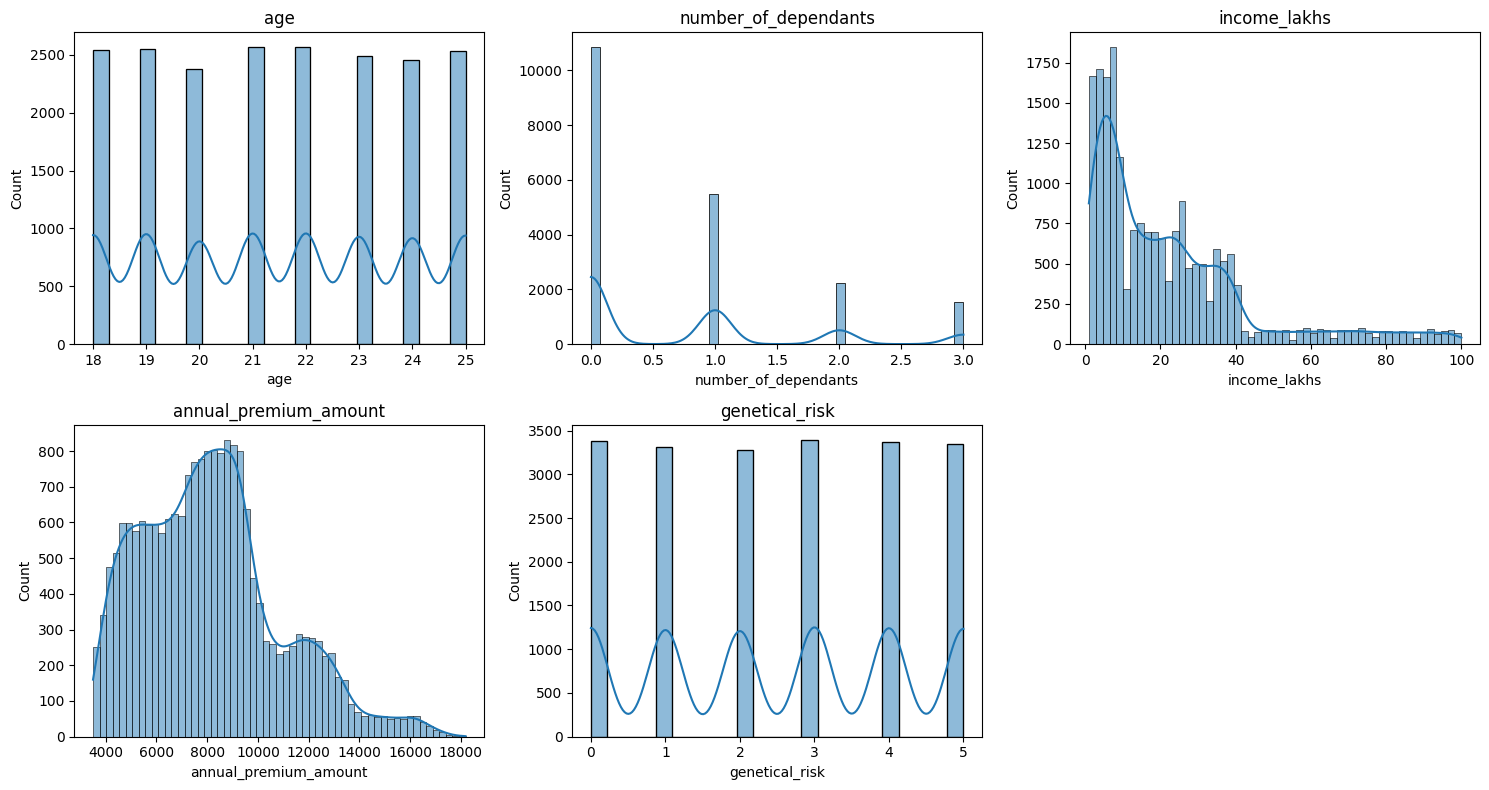

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 cols
axes = axes.flatten()

# Loop through each column and subplot
for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Hide the last empty subplot (if numeric_columns has only 5)
if len(numeric_columns) < len(axes):
    for j in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

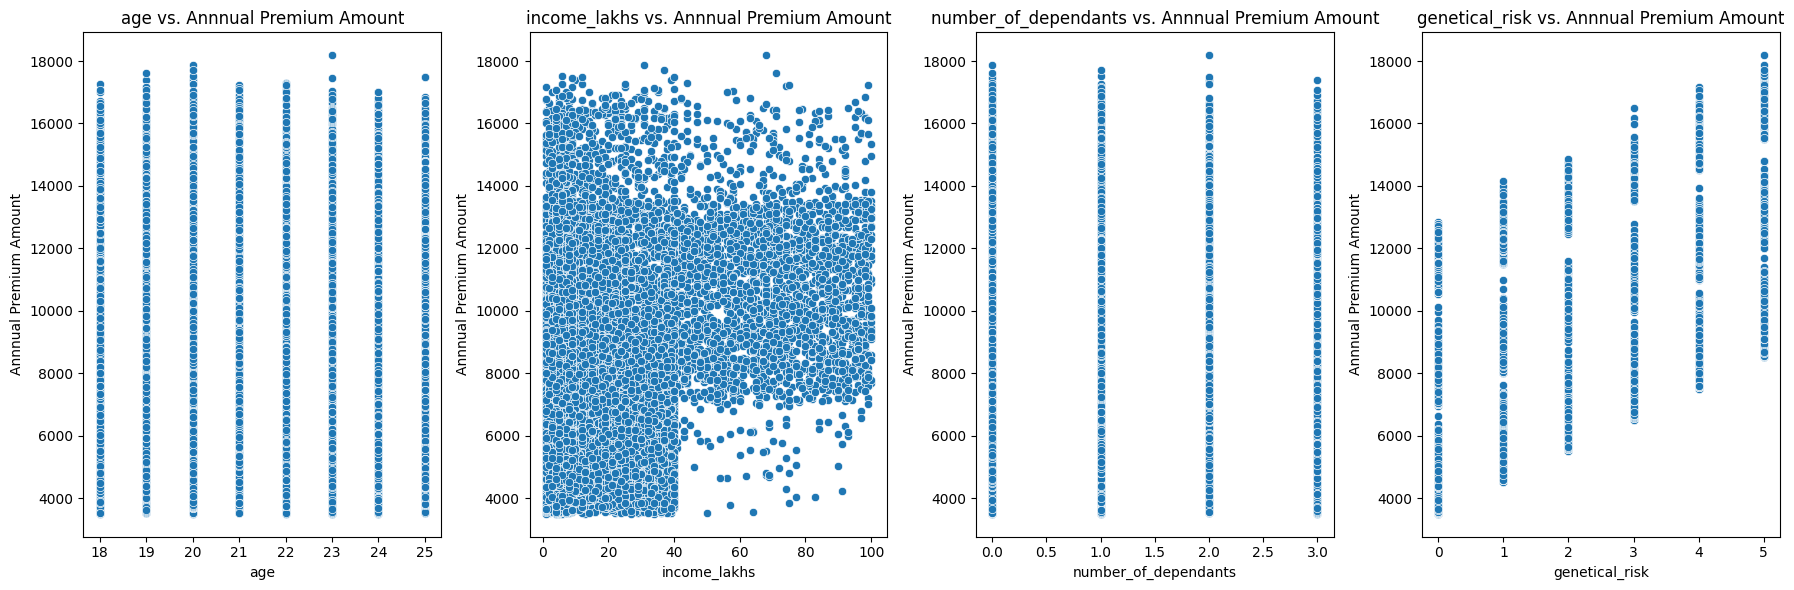

In [27]:
numeric_features = ['age','income_lakhs','number_of_dependants','genetical_risk']

fig,axes = plt.subplots(1,len(numeric_features),figsize=(18,6))

for ax,col in zip(axes,numeric_features):
    sns.scatterplot(x=df2[col],y=df2['annual_premium_amount'],ax=ax)
    ax.set_title(f'{col} vs. Annnual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annnual Premium Amount')

plt.tight_layout()
plt.show()

In [28]:
categorical_cols = df2.select_dtypes('object').columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [29]:
for col in categorical_cols:
    print(col,':',df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [30]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Not Smoking':'No Smoking',
    'Does Not Smoke':'No Smoking'
},inplace=True)
df2['smoking_status'].unique() 

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [31]:
pct_count = df['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550274
Female    0.449726
Name: proportion, dtype: float64

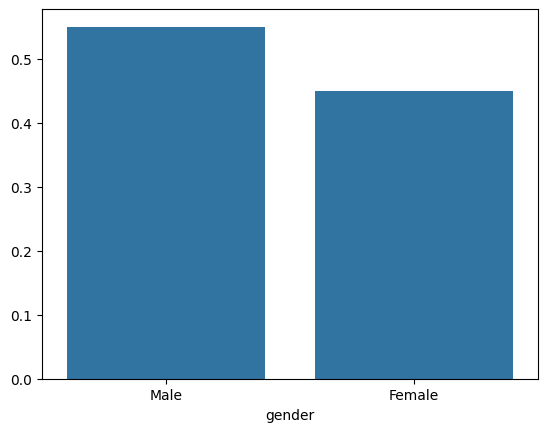

In [32]:
sns.barplot(x=pct_count.index,y=pct_count.values)
plt.show()

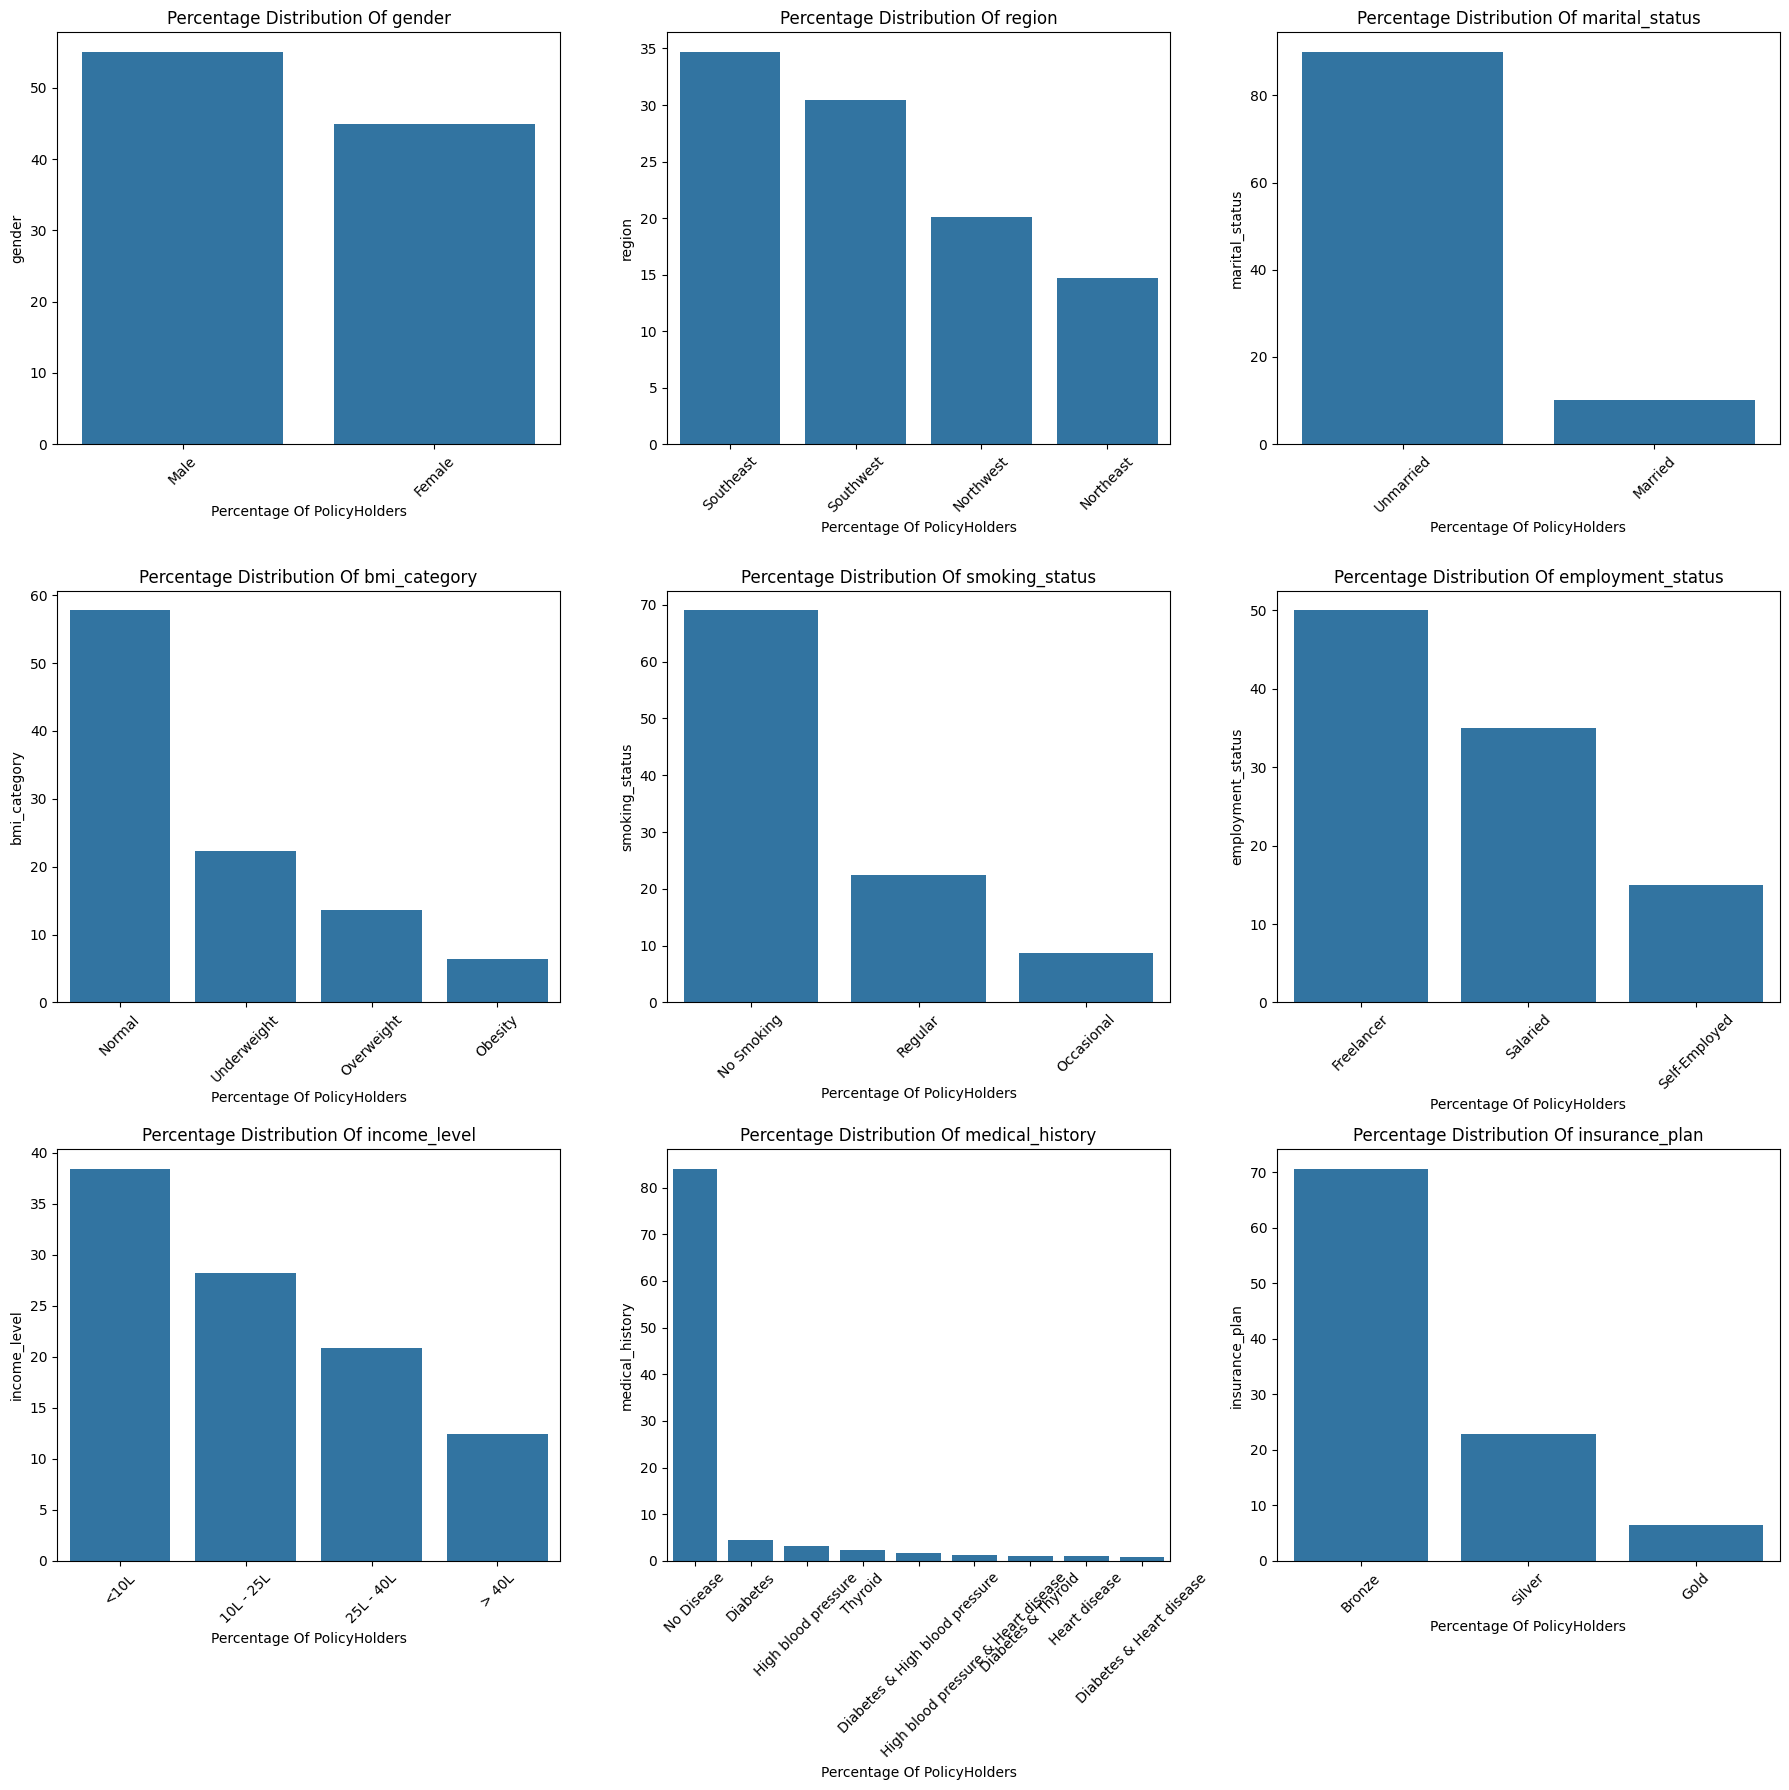

In [33]:
fig , axes = plt.subplots(3,3,figsize=(18,18))
axes = axes.flatten()

for ax,col in zip(axes,categorical_cols):
    category_counts = df2[col].value_counts(normalize=True)*100

    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(f'Percentage Distribution Of {col}')
    ax.set_xlabel('Percentage Of PolicyHolders')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


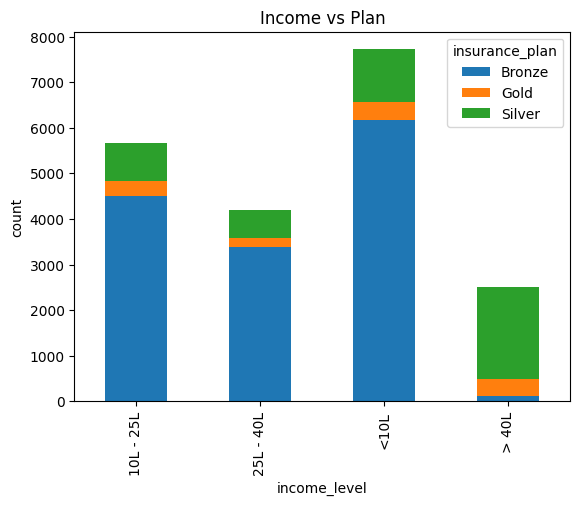

In [34]:
crosstab = pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar',stacked=True)
plt.title('Income vs Plan')
plt.ylabel('count')
plt.show()

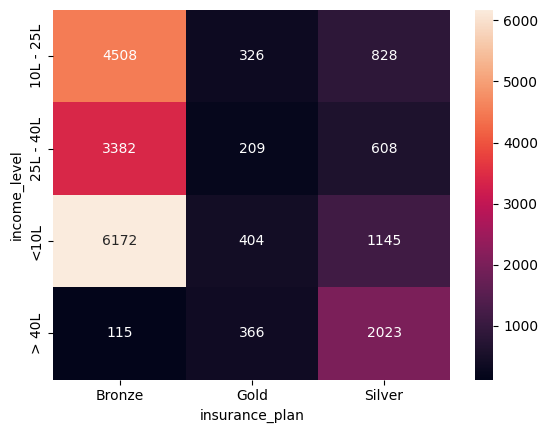

In [35]:
sns.heatmap(crosstab,annot=True,fmt='d')
plt.show()

### Feature Engineering

In [36]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [37]:
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [38]:
risk_scores = {
    'diabetes' :6,
    'heart disease':8,
    'high blood pressure': 6,
    'thyroid':5,
    'no disease':0,
    'none':0
}

In [39]:
df2[['disease1','disease2']] = df2['medical_history'].str.split(' & ',expand=True).apply(lambda x : x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,None


In [40]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1','disease2'] :
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score-min_score)
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none,0,0.000000


In [41]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [42]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1,'Silver':2,'Gold':3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [43]:
df2['income_level'].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [44]:
df2['income_level'] = df2['income_level'].map({'<10L':1,'10L - 25L':2,'> 40L':3 ,'25L - 40L':4 })
df2['income_level'].unique()

array([3, 1, 2, 4])

In [45]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,3,97,No Disease,2,11857,4,no disease,none,0,0.000000


In [46]:
nominal_cols = ['gender','region','marital_status','bmi_category','smoking_status','employment_status']

df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype='int')
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [47]:
df4 = df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


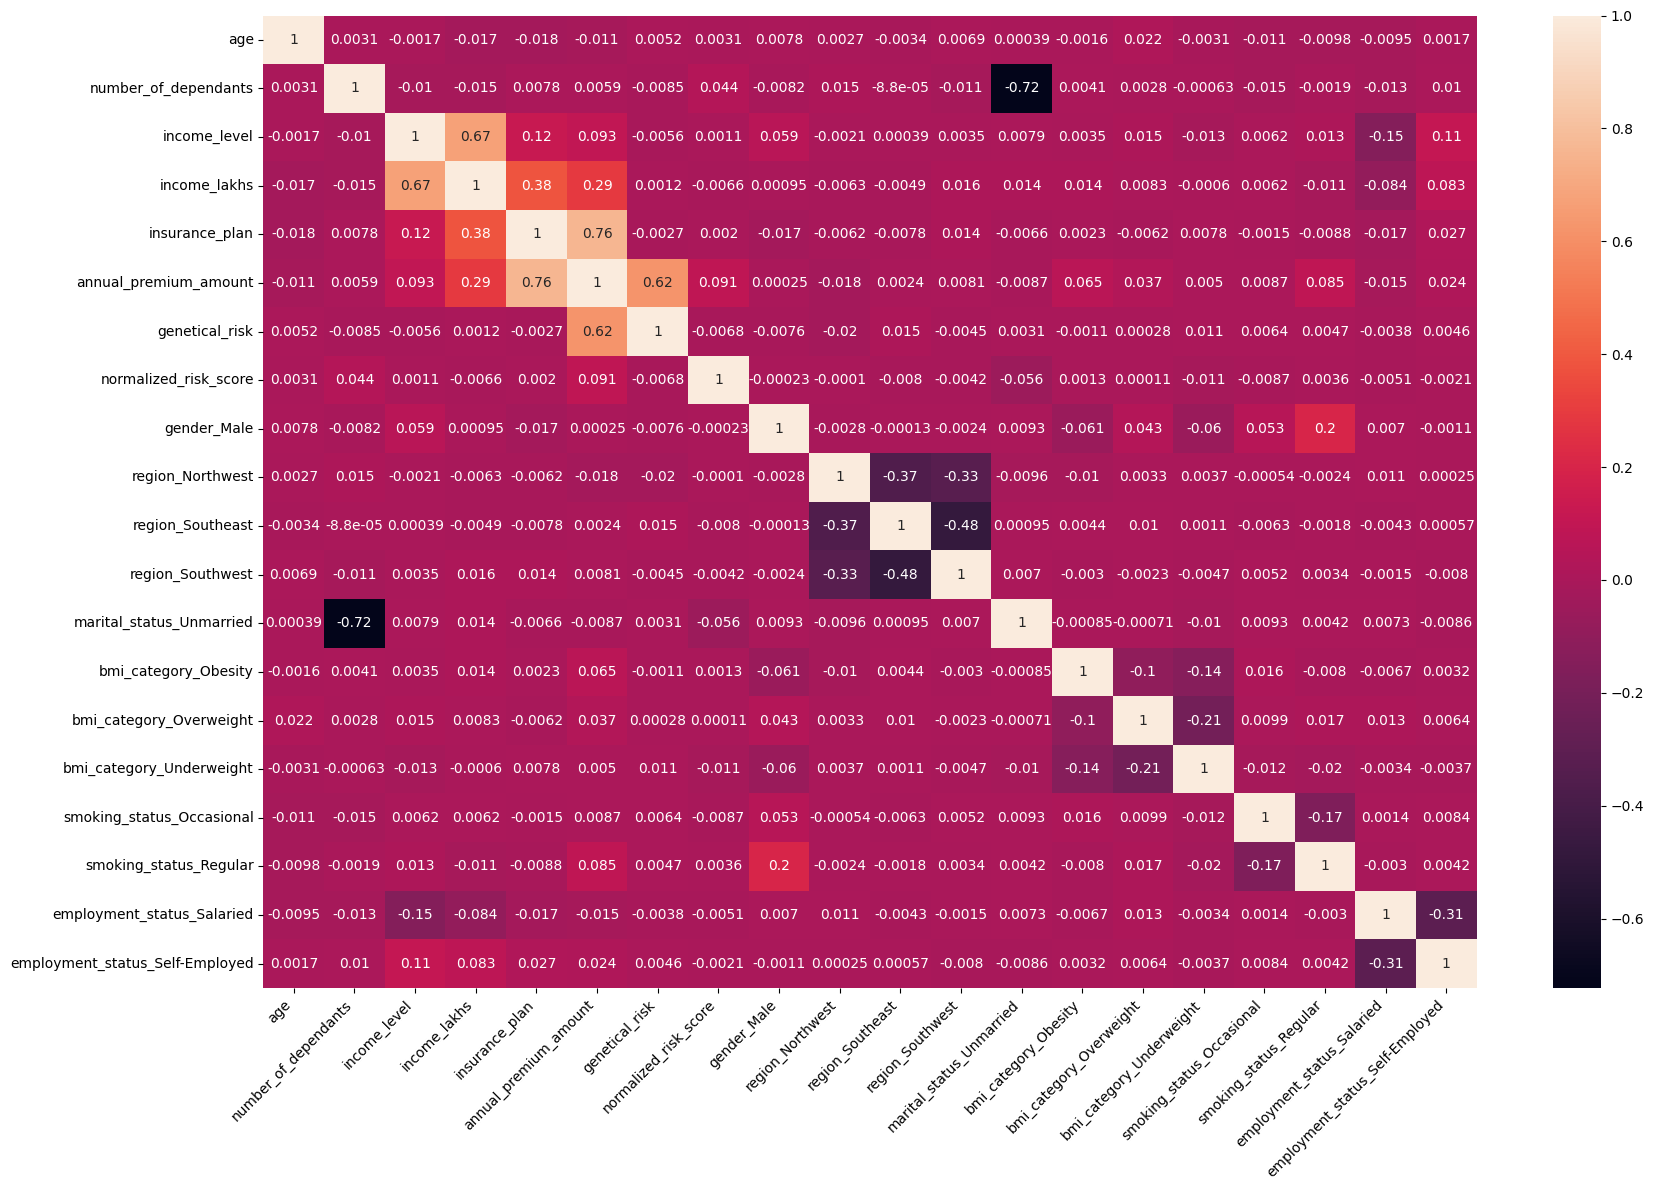

In [48]:
cm = df4.corr()

plt.figure(figsize=(18,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [49]:
df4.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0


In [54]:
X = df4.drop('annual_premium_amount',axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan','genetical_risk']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.386123,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.383007,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [56]:
calculate_vif(X.drop('income_level',axis=1))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [57]:
X_redcued = X.drop('income_level',axis=1)
X_redcued.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Model Training

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X_redcued,y,test_size=0.3,random_state=10)

print('X train :',X_train.shape)
print('X test :',X_test.shape)
print('y train :',y_train.shape)
print('y test :',y_test.shape)

X train : (14060, 18)
X test : (6026, 18)
y train : (14060,)
y test : (6026,)


In [59]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)
train_score,test_score

(0.988297900194864, 0.9887263253056615)

In [60]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print('LinearRegression ==> MSE : ',mse_lr,'RMSE :',rmse_lr)

LinearRegression ==> MSE :  85732.34377930452 RMSE : 292.8008602776032


In [61]:
model_lr.intercept_

np.float64(3978.8235284382563)

In [62]:
model_lr.coef_

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        4.99698873e+03,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

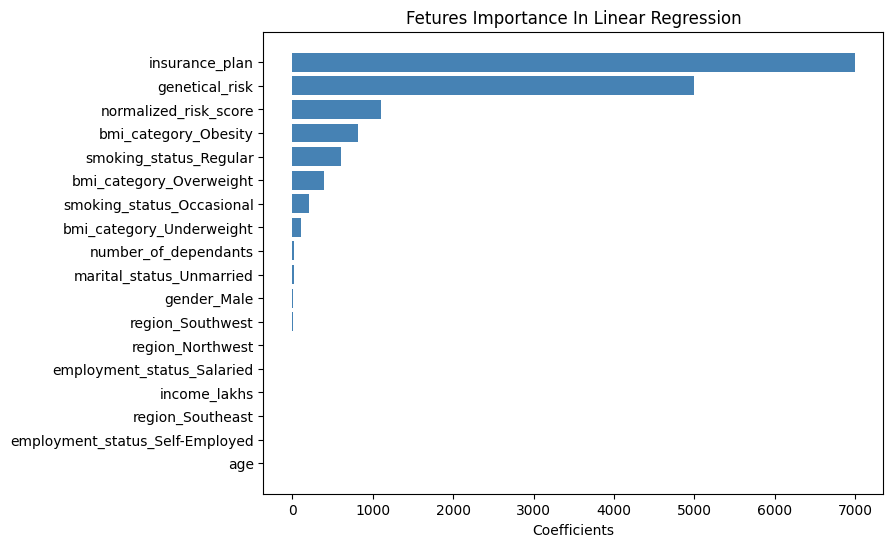

In [63]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(coef_df.index,coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficients')
plt.title('Fetures Importance In Linear Regression')
plt.show()

In [64]:
model_rg = Ridge(alpha=5)
model_rg.fit(X_train,y_train)
model_rg.score(X_test,y_test)
train_score = model_rg.score(X_train,y_train)
test_score = model_rg.score(X_test,y_test)
train_score,test_score

(0.9882829235509011, 0.9887204934859328)

In [65]:
y_pred = model_rg.predict(X_test)

mse_rg = mean_squared_error(y_test,y_pred)
rmse_rg = np.sqrt(mse_rg)
print('Ridge ==> MSE : ',mse_rg,'RMSE :',rmse_rg)

Ridge ==> MSE :  85776.69272384958 RMSE : 292.8765827509082


In [66]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)
train_score = model_xgb.score(X_train,y_train)
test_score = model_xgb.score(X_test,y_test)
train_score,test_score

(0.9925054907798767, 0.987729549407959)

In [67]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test,y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print('XGBoostRegresion ==> MSE : ',mse_xgb,'RMSE :',rmse_xgb)

XGBoostRegresion ==> MSE :  93312.703125 RMSE : 305.47128036036383


In [68]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5]
}

random_search = RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42)
random_search.fit(X_train,y_train)
random_search.best_score_

np.float64(0.9879226088523865)

In [61]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [69]:
best_model = model_lr

### Error Analysis

In [70]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct':residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6121.456891,-116.543109,-1.868277
14758,9462,9601.797510,139.797510,1.477463
13205,5152,5611.056493,459.056493,8.910258
14278,6988,7423.486322,435.486322,6.231916
19351,4917,5112.056543,195.056543,3.966983


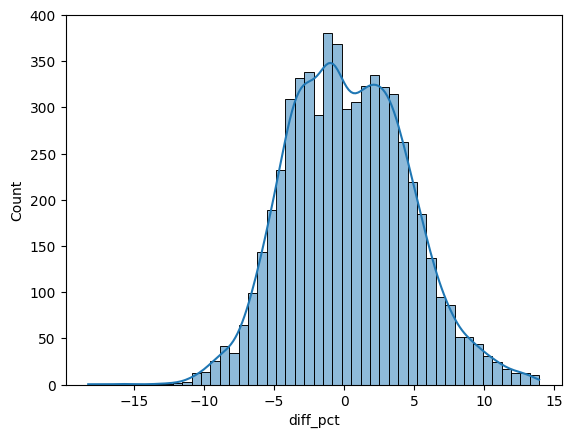

In [71]:
sns.histplot(results_df['diff_pct'],kde=True)
plt.show()

In [72]:
extreme_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_threshold]
extreme_results_df.shape

(129, 4)

In [73]:
extreme_errors_pct = extreme_results_df.shape[0]*100 / results_df.shape[0]
extreme_errors_pct

2.140723531364089

In [74]:
results_df[np.abs(results_df['diff_pct']) > 50].sort_values('diff_pct',ascending=False)

,actual,predicted,diff,diff_pct


In [75]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [76]:
extreme_results_df.index

Index([12669,  2918, 17084,  7181, 12285, 13476, 15481,  2948,  4919, 15170,
       ...
       15166, 19580, 15664,  4204,  8692,  1986,  8008,  9714,  7357,  1534],
      dtype='int64', length=129)

In [77]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.000000,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.000000,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.000000,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
7181,0.571429,0.000000,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.232323,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0


### Export The Model

In [86]:
from joblib import dump
dump(best_model,'artifacts/model_young.joblib')
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale':cols_to_scale
}
dump(scaler_with_cols,'artifacts/scaler_young.joblib')

['artifacts/scaler_young.joblib']

In [85]:
scaler_with_cols

{'scaler': MinMaxScaler(),
 'cols_to_scale': ['age',
  'number_of_dependants',
  'income_level',
  'income_lakhs',
  'insurance_plan',
  'genetical_risk']}